In [36]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

In [37]:
data =  pd.read_csv('Mecca.csv', header=0)
train_percent=0.60
num_epochs=150

In [38]:
data.head()

,Date,Value
0,1-Jan-01,10.2
1,1-Feb-01,3.1
2,1-Mar-01,6.1
3,1-Apr-01,7.1
4,1-May-01,3.4


In [39]:
print(len(data['Value'].unique()))
symbols = data['Value'].unique()

248


In [40]:
data['Value'].describe()

count    1452.000000
mean        6.188085
std         8.052472
min         0.000000
25%         0.200000
50%         3.000000
75%         9.600000
max        52.000000
Name: Value, dtype: float64

In [41]:
#random.seed(42)  #explain!
choosen_symbol = random.choice(symbols)
print(choosen_symbol)

30.1


In [42]:
data_mod = data.drop(['Date'], axis=1)

In [43]:
data_mod

,Value
0,10.2
1,3.1
2,6.1
3,7.1
4,3.4
...,...
1447,0.1
1448,0.3
1449,2.4
1450,14.2


In [44]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_mod_scaled = sc.fit_transform(data_mod)

In [45]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [46]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_mod_scaled, n_future=1, n_past=25, train_test_split_percentage=train_percent,
                                               validation_split_percentage = 0)


In [47]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(856, 25, 1)
(571, 25, 1)
(856, 1)
(571, 1)


In [48]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
regressor.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_154 (LSTM)             (None, 25, 16)            1152      
                                                                 
 dropout_154 (Dropout)       (None, 25, 16)            0         
                                                                 
 lstm_155 (LSTM)             (None, 16)                2112      
                                                                 
 dropout_155 (Dropout)       (None, 16)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [49]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=64)
#history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=64, callbacks=[es])

Epoch 1/150
10/10 [==============================] - 3s 61ms/step - loss: 0.0269 - root_mean_squared_error: 0.1641 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1550
Epoch 2/150
10/10 [==============================] - 0s 16ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 3/150
10/10 [==============================] - 0s 14ms/step - loss: 0.0249 - root_mean_squared_error: 0.1579 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1528
Epoch 4/150
10/10 [==============================] - 0s 15ms/step - loss: 0.0250 - root_mean_squared_error: 0.1582 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 5/150
10/10 [==============================] - 0s 13ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 6/150
10/10 [==============================] - 0s 16ms/step - loss: 0.0241 - root_mean_squared_error: 0.1554 - val_loss: 0.0221 - val_

In [50]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

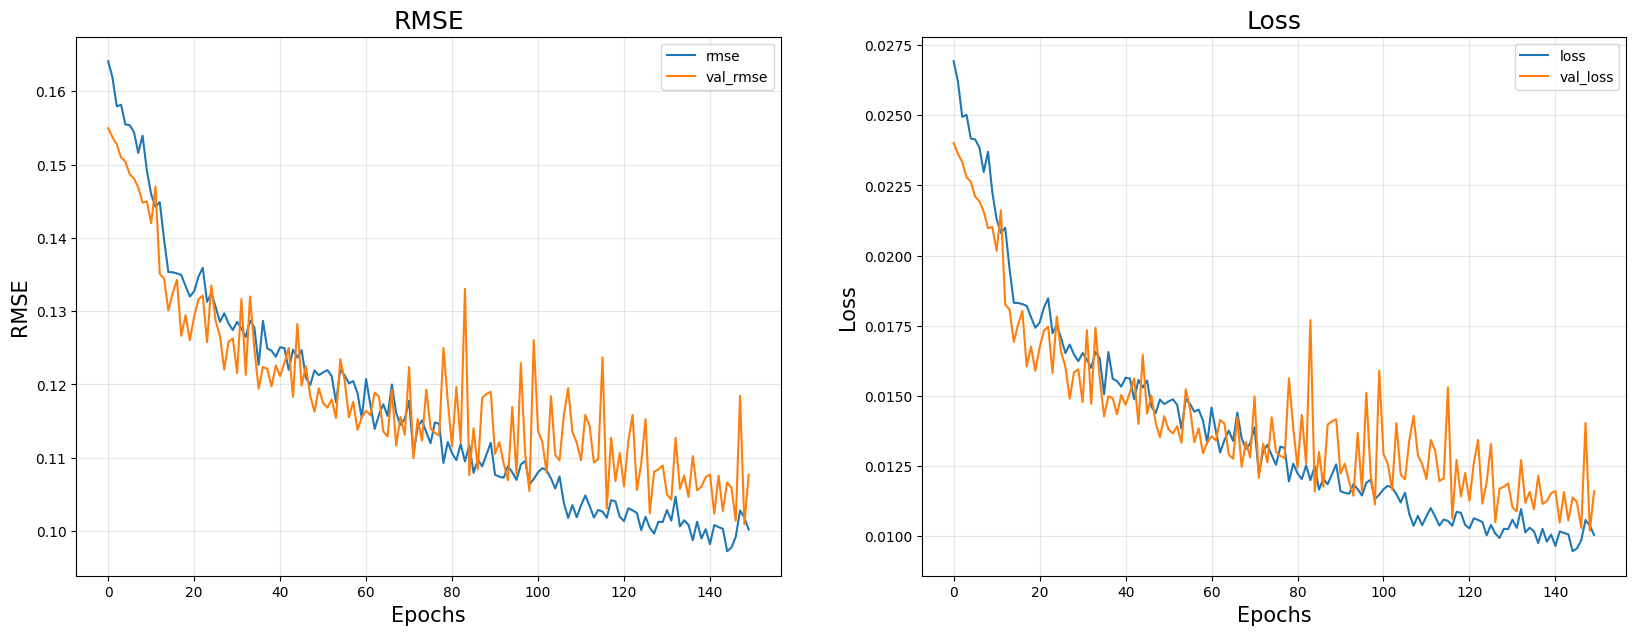

In [51]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)
# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")
plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#Adding Subplot 1 (For Loss)
fig.add_subplot(122)
plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")
plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [52]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

18/18 [==============================] - 0s 2ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201
test loss, test acc: [0.0144 0.1201]


In [53]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
from keras.layers import Bidirectional , GRU

def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, callbacks=[es, mc], verbose=1)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [54]:
config = [[False], [False], [False], [8,16, 32, 64, 128], [8, 16, 32, 64, 128], [0.2,0.3,0.5]]  
# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]
hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 8, 8, 0.2), (False, False, False, 8, 8, 0.3), (False, False, False, 8, 8, 0.5), (False, False, False, 8, 16, 0.2), (False, False, False, 8, 16, 0.3), (False, False, False, 8, 16, 0.5), (False, False, False, 8, 32, 0.2), (False, False, False, 8, 32, 0.3), (False, False, False, 8, 32, 0.5), (False, False, False, 8, 64, 0.2), (False, False, False, 8, 64, 0.3), (False, False, False, 8, 64, 0.5), (False, False, False, 8, 128, 0.2), (False, False, False, 8, 128, 0.3), (False, False, False, 8, 128, 0.5), (False, False, False, 16, 8, 0.2), (False, False, False, 16, 8, 0.3), (False, False, False, 16, 8, 0.5), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 16, 0.3), (False, False, False, 16, 16, 0.5), (False, False, False, 16, 32, 0.2), (False, False, False, 16, 32, 0.3), (False, False, False, 16, 32, 0.5), (False, False, False, 16, 64, 0.2), (False, False, False, 16, 64, 0.3), (False, False, False, 16, 64, 0.5), (False, False, False, 16, 128, 0.2), (False, 

In [55]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
16,False,False,False,16,8,0.3,"[0.008025599643588066, 0.08958571404218674]","[0.013003545813262463, 0.11403308808803558]"
21,False,False,False,16,32,0.2,"[0.007807936519384384, 0.08836252987384796]","[0.013223356567323208, 0.11499285697937012]"
20,False,False,False,16,16,0.5,"[0.008295003324747086, 0.09107691049575806]","[0.013233602046966553, 0.11503739655017853]"
31,False,False,False,32,8,0.3,"[0.008264871314167976, 0.09091133624315262]","[0.013272911310195923, 0.11520811915397644]"
33,False,False,False,32,16,0.2,"[0.008550678379833698, 0.09246987849473953]","[0.0133995171636343, 0.11575628072023392]"
...,...,...,...,...,...,...,...,...
3,False,False,False,8,16,0.2,"[0.014101605862379074, 0.1187501847743988]","[0.018951408565044403, 0.13766410946846008]"
29,False,False,False,16,128,0.5,"[0.015760263428092003, 0.1255398839712143]","[0.019695620983839035, 0.14034108817577362]"
12,False,False,False,8,128,0.2,"[0.016234207898378372, 0.1274135261774063]","[0.02010991796851158, 0.14180944859981537]"
14,False,False,False,8,128,0.5,"[0.020668407902121544, 0.14376510679721832]","[0.02307162806391716, 0.1518934816122055]"


In [56]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 8
 dropout = 0.3
**************************
Results Before Tunning:
 Test Set RMSE: 0.1201

Results After Tunning:
 Test Set RMSE: 0.114

5.0% Improvement


In [57]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [58]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
file_path = 'best_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history_2=regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, verbose=1)
#history_2=regressor.fit(X_train, y_train, validation_split=0.3, epochs=num_epochs, batch_size=n_batch_size, callbacks=[es], verbose=1)

Epoch 1/150
75/75 [==============================] - 3s 15ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1495
Epoch 2/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0239 - root_mean_squared_error: 0.1547 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516
Epoch 3/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1473
Epoch 4/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 5/150
75/75 [==============================] - 1s 11ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1302
Epoch 6/150
75/75 [==============================] - 1s 11ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0158 - val_

In [59]:
regressor.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142


[0.013046737760305405, 0.11422231793403625]

In [60]:
history_2.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

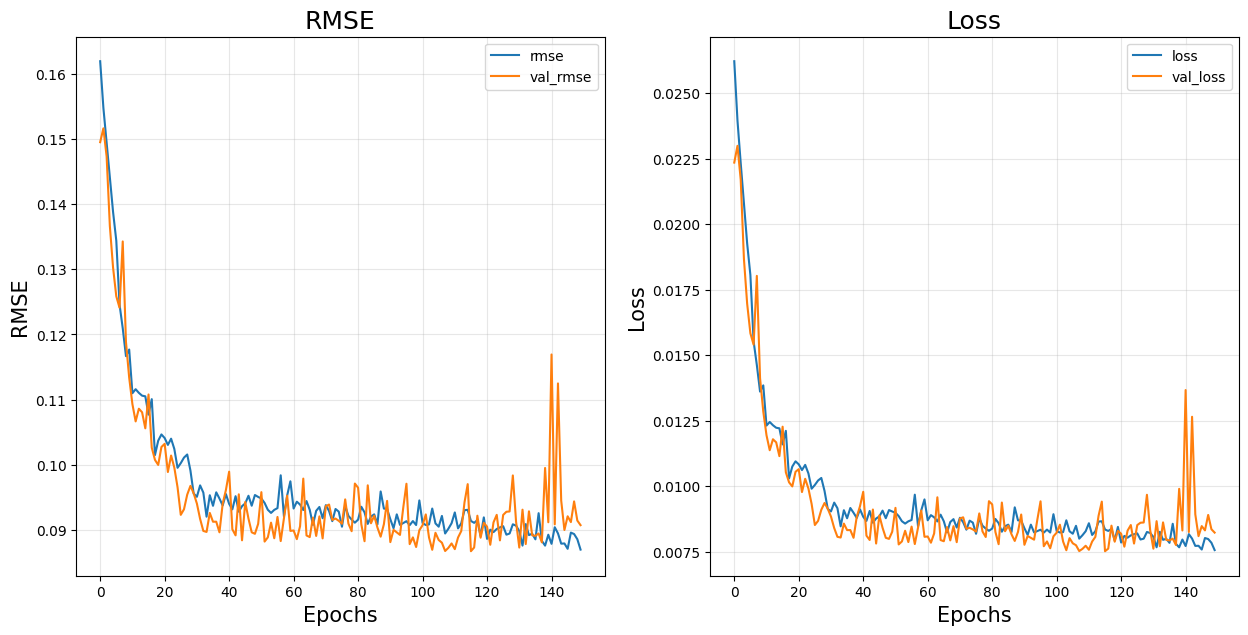

In [61]:
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
# Accuracy
plt.plot(history_2.epoch, history_2.history['root_mean_squared_error'], label = "rmse")
plt.plot(history_2.epoch, history_2.history['val_root_mean_squared_error'], label = "val_rmse")
plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
#Adding Subplot 1 (For Loss)
fig.add_subplot(122)
plt.plot(history_2.epoch, history_2.history['loss'], label="loss")
plt.plot(history_2.epoch, history_2.history['val_loss'], label="val_loss")
plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

18/18 [==============================] - 0s 3ms/step


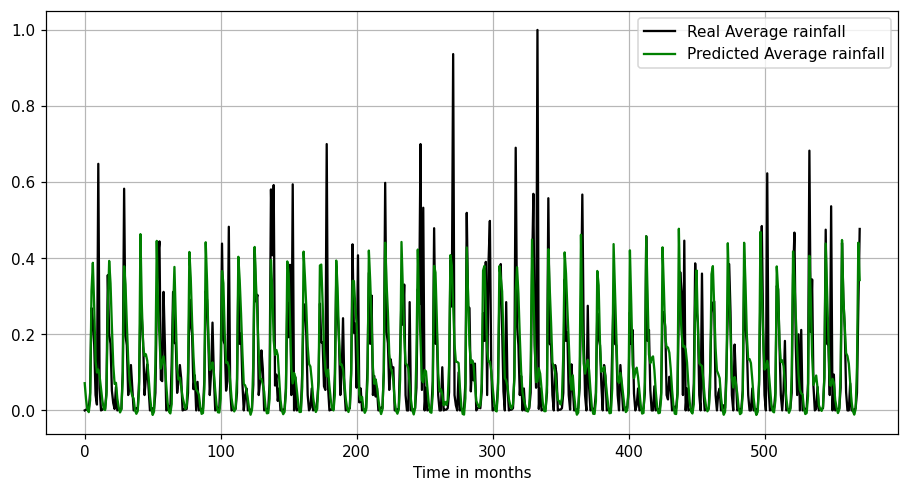

In [62]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,5), dpi= 110, facecolor='w', edgecolor='k')
plt.plot(y_test, color='black', label = 'Real Average rainfall')
plt.plot(y_pred, color='green', label = 'Predicted Average rainfall')
plt.legend(loc='best')
plt.xlabel('Time in months')
plt.grid(alpha=0.9)
plt.legend()


18/18 [==============================] - 0s 2ms/step


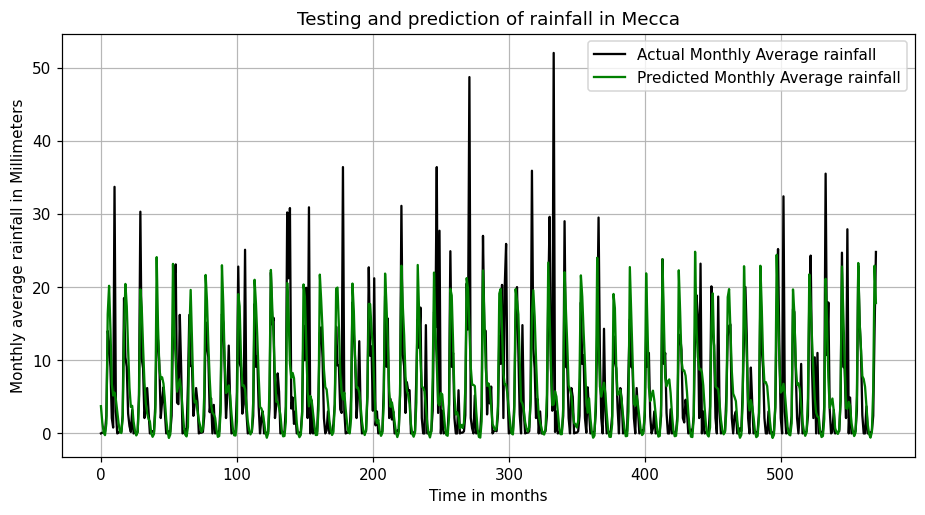

In [63]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,5), dpi= 110, facecolor='w', edgecolor='k')
y_test_sc = sc.inverse_transform(y_test)
y_pred_sc = sc.inverse_transform(y_pred)
plt.plot(y_test_sc, color='black', label = 'Actual Monthly Average rainfall')
plt.plot(y_pred_sc, color='green', label = 'Predicted Monthly Average rainfall')
plt.legend(loc='best')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.xlabel('Time in months')
plt.ylabel('Value')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Testing and prediction of rainfall in Mecca')
plt.grid(alpha=0.9)
plt.legend()

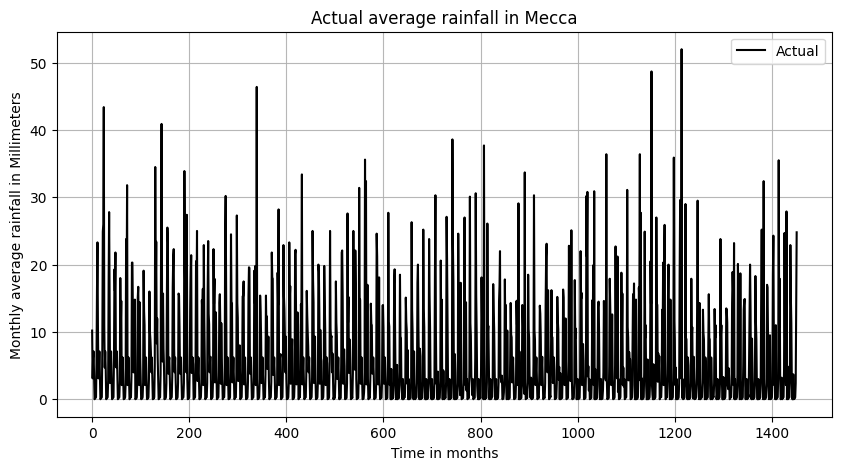

In [64]:
plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(data['Value'], color='black', label = 'Actual')
plt.grid(alpha=0.9)
plt.xlabel('Time in months')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Actual average rainfall in Mecca')
plt.legend(loc='best')

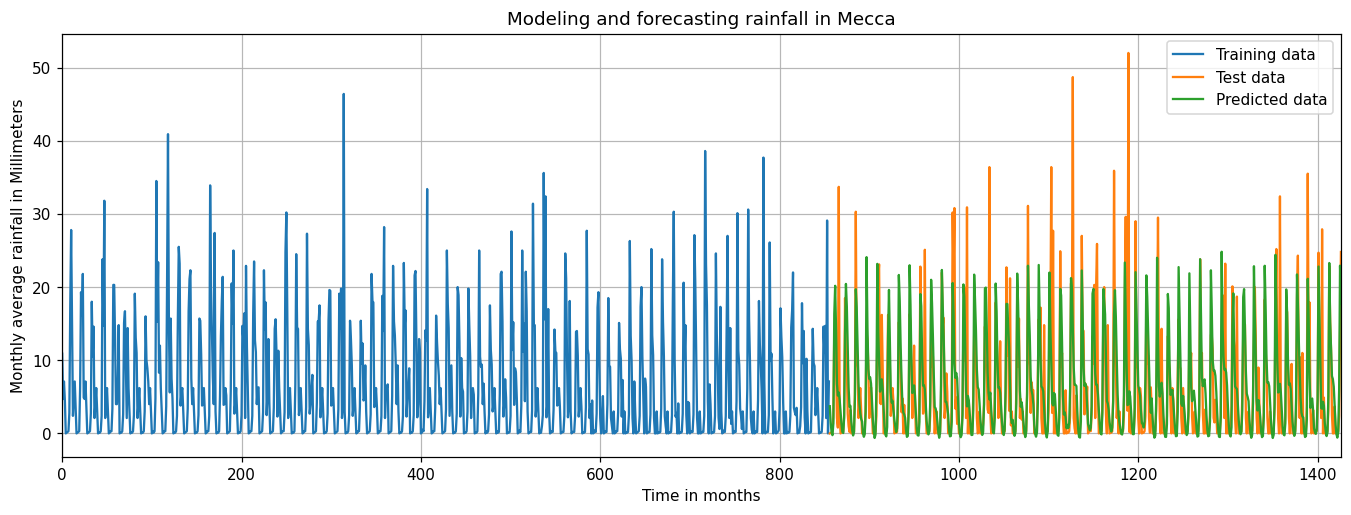

In [65]:
import matplotlib.pyplot as plt
# Create an array of time values corresponding to the length of each dataset
time_train = range(len(y_train))
time_test = range(len(y_train), len(y_train) + len(y_test))
fig = plt.figure(figsize=(15,5), dpi= 110)
# Plot the data using line plots with time on the x-axis
plt.plot(time_train, sc.inverse_transform(y_train), label='Training data')
plt.plot(time_test, sc.inverse_transform(y_test), label='Test data')
plt.plot(time_test, sc.inverse_transform(y_pred), label='Predicted data')
plt.legend()
plt.xlabel('Time in months')
plt.ylabel('Value')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Modeling and forecasting rainfall in Mecca')
plt.legend(loc='best')
plt.grid(alpha=0.9)
plt.xlim([min(time_train), max(time_test)])
plt.grid(alpha=0.9)
plt.show()

In [66]:
# set x_forcast to be the input data
x_forcast = X_test[-1::]
y_forcast = []
n_forecast=730
for _ in range(n_forecast): 
    
    # predict y values with the regression model
    y_forcast_temp = regressor.predict(x_forcast)
    x_forcast = np.append(x_forcast[:,1:,:], np.array(y_forcast_temp).reshape(1,1,1), axis=1)
    
    
    # append the y_forcast to the end of x_forcast
    y_forcast.append(y_forcast_temp.reshape(1))


1/1 [==============================] - 0s 15ms/step


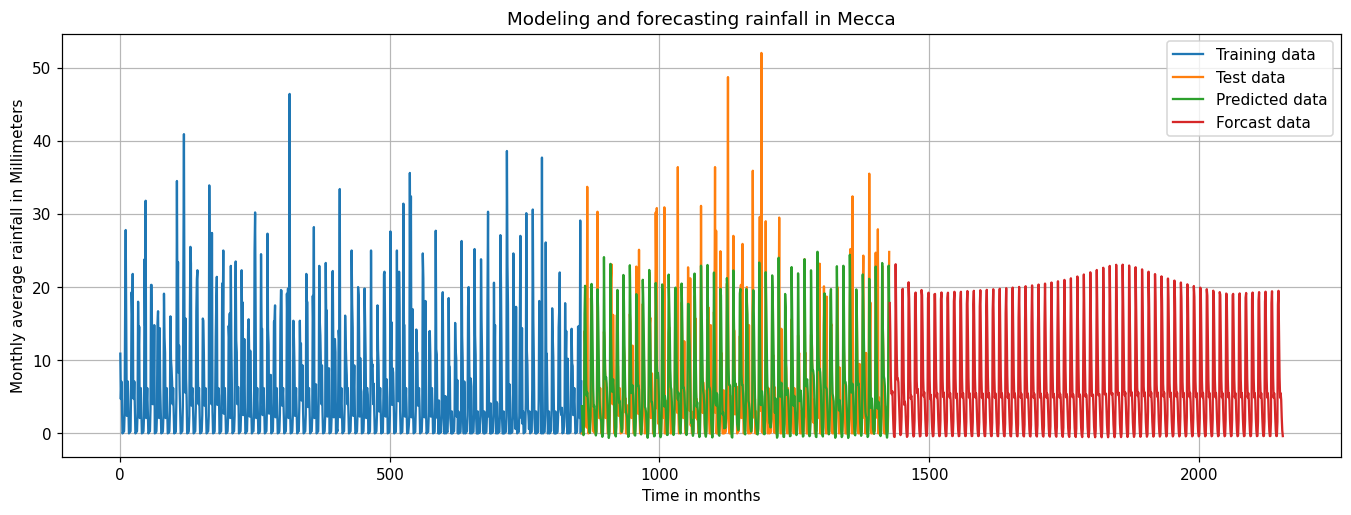

In [67]:
import matplotlib.pyplot as plt
# Create an array of time values corresponding to the length of each dataset
time_train = range(len(y_train))
time_test = range(len(y_train), len(y_train) + len(y_test))
time_forecast = range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_forcast))
fig = plt.figure(figsize=(15,5), dpi= 110)
# Plot the data using line plots with time on the x-axis
plt.plot(time_train, sc.inverse_transform(y_train), label='Training data')
plt.plot(time_test, sc.inverse_transform(y_test), label='Test data')
plt.plot(time_test, sc.inverse_transform(y_pred), label='Predicted data')
plt.plot(time_forecast, sc.inverse_transform(y_forcast), label='Forcast data')
plt.legend()
plt.xlabel('Time in months')
plt.ylabel('Value')
plt.ylabel('Monthly average rainfall in Millimeters')
plt.title('Modeling and forecasting rainfall in Mecca')
plt.legend(loc='best')
plt.grid(alpha=0.9)
# plt.xlim([min(time_train), max(time_forecast)])
plt.grid(alpha=0.9)
plt.show()

In [68]:
X_train.shape

(856, 25, 1)

In [69]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test_sc, y_pred_sc)   # 5500  
mae = mean_absolute_error(y_test_sc, y_pred_sc)
mape = mean_absolute_percentage_error(y_test_sc, y_pred_sc)*100
r2_Squared = r2_score(y_test_sc, y_pred_sc)
rmse = np.sqrt(mse)
rrmse= np.sqrt(rmse)
print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print('X_test MAPE:{}%'.format(mape))
#print(f'X_test RMSLE: {rmsle}')
print(f'R-Squared: {r2_Squared}')
print(f'X_test RMSE: {rmse}')
print(f'X_test RRMSE: {rrmse}')

X_test MSE: 35.27837690467259
X_test MAE: 3.542128290311676
X_test MAPE:2.1421379420591568e+17%
R-Squared: 0.46453874461374844
X_test RMSE: 5.939560329239243
X_test RRMSE: 2.437121320172478
